In [38]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
from dotenv import load_dotenv


load_dotenv()
token = os.getenv('IBM_TOKEN')
algorithm_globals.random_seed = 42


### Function to calculate time

In [2]:


def timeit(func):
    """Decorator to measure the execution time of a function and return it along with the function's result."""
    
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record the start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.time()  # Record the end time
        execution_time = end_time - start_time  # Calculate execution time
        return result, execution_time
    
    return wrapper


#### Iris Dataset

In [3]:

iris_data = load_iris()

In [4]:
features = iris_data.data
labels = iris_data.target

In [5]:

features = MinMaxScaler().fit_transform(features)

In [6]:


train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

The number of qubits is equal to the number of features

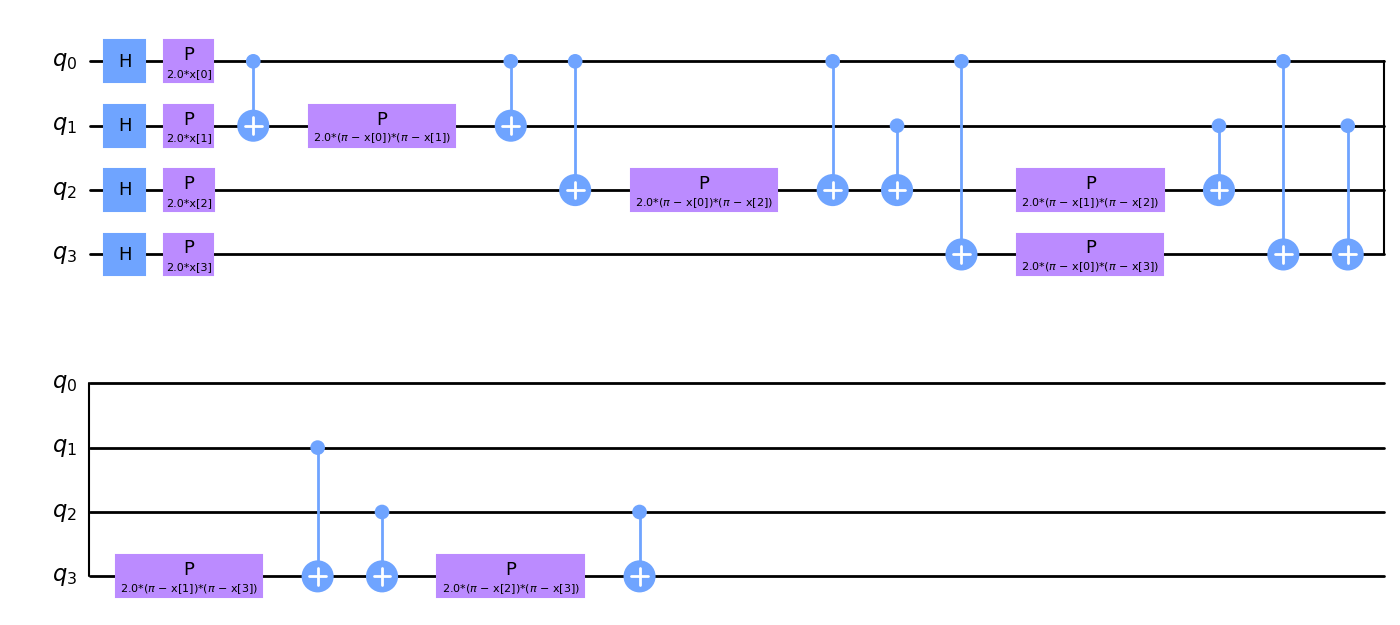

In [7]:

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

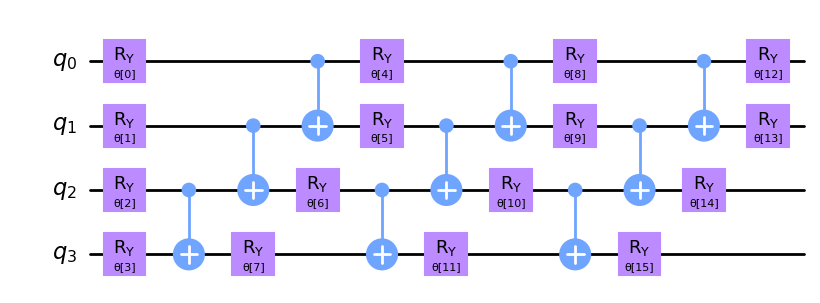

In [8]:

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [9]:

optimizer = COBYLA(maxiter=100)

In [10]:

sampler_loc = Sampler()

In [11]:


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [12]:

vqc = VQC(
    sampler=sampler_loc,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []


In [13]:
@timeit
def fit_vqc(trainable_vqc: VQC, q_features=train_features, q_labels=train_labels):
    trainable_vqc.fit(q_features,q_labels)
    

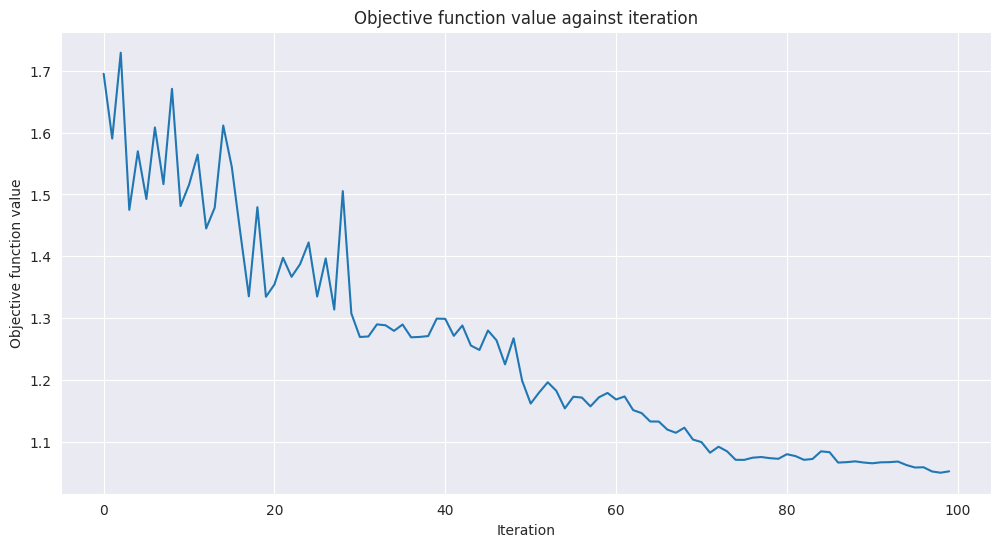

In [14]:


result, execution_time = fit_vqc(trainable_vqc=vqc, q_features=train_features, q_labels=train_labels)

In [15]:
print(f"Execution time when ran locally: {round(execution_time)} seconds")

Execution time when ran locally: 100 seconds


### Backend simulation on IBM

In [39]:

service = QiskitRuntimeService(channel="ibm_quantum")
options_new= Options(optimization_level=3)
options_new.execution.shots = 1024
backend = service.get_backend('ibmq_qasm_simulator')


In [40]:
sampler_sim = Sampler(backend=backend,options=options_new)


In [41]:

vqc_sim = VQC(
    sampler=sampler_sim,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)


In [43]:
objective_func_vals = []
result,execution_time = fit_vqc(trainable_vqc=vqc_sim, q_features=train_features, q_labels=train_labels)
print(f"Execution time when ran on qasm simulator: {round(execution_time)} seconds")


KeyboardInterrupt: 

#### Running on real quantum hardware

In [44]:

options_new= Options(optimization_level=3)
options_new.execution.shots=1024
options_new.execution.shots = 1024
backend_real = service.least_busy(operational=True, simulator=False)



In [45]:
sampler_real = Sampler(backend=backend_real,options=options_new)

In [46]:
vqc_real = VQC(
    sampler=sampler_real,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

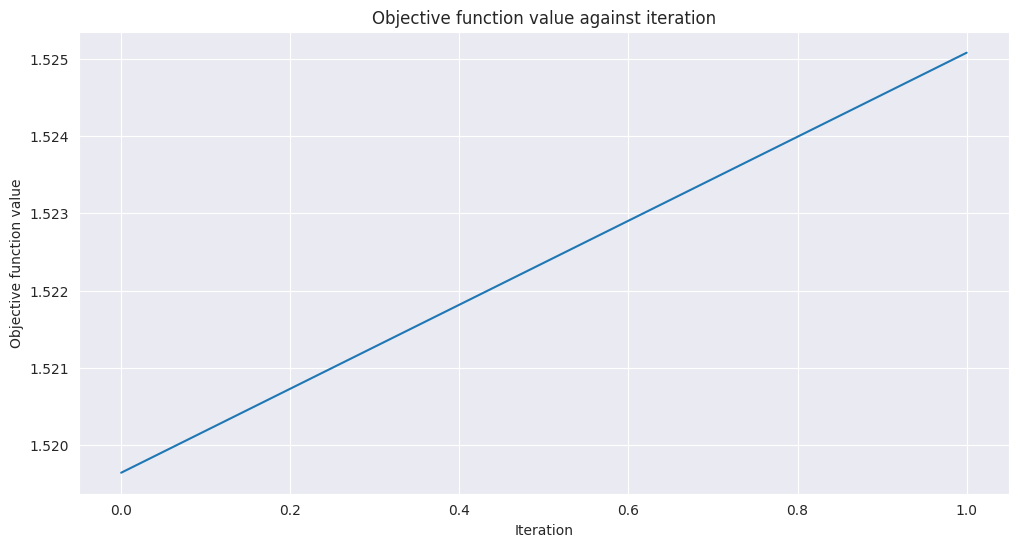

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [47]:
objective_func_vals = []
result,execution_time = fit_vqc(trainable_vqc=vqc_real, q_features=train_features, q_labels=train_labels)
print(f"Execution time when ran on real quantum hardware: {round(execution_time)} seconds")

Good fucking luck running anything on the quantum computer, lmao